Predictions of Annual Medical Expenditure
---

Thao Tran

## Introduction



In this anlysis, we use neural networks to provide predictions on annual insurance premium (amount paid every month) offered to the customer based on their age, sex, BMI, children, smoking habits and region of residence. The goal is to estimate annual medical expenditure for new customers using the above measures. Our data of over 1300 customers comes from Kaggle, ["Medical Insurance Payout"](https://www.kaggle.com/datasets/harshsingh2209/medical-insurance-payout?resource=download), with the following variables:


* `age`: Age of the customer
* `sex`: Gender
* `bmi`: Body Mass Index, an important health factor
* `children`: Number of children
* `smoker`: Whether the customer smokes or not
* `region`: Region of the country the customer resides
* `charges`: The annual insurance expenditure for the customer



In [1]:
#load library
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
#plots
import seaborn as sns
import matplotlib.pyplot as plt
# Keras
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [2]:
#load data
med = pd.read_csv("expenses.csv")
med.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis



We have 1338 records of customers, who have an average age of 39 and bmi of 31. There is an even distrbution of observations across sex and four regions, and about a fifth of customer records are smokers.  

In [3]:
med.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [4]:
med.describe(include = ['object'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Our target variable, `charges`, is unimodal and right-skewed with an average of \$13,270.42 and standard deviation of \$12,110.01. While the annual medical expenditure ranges from \$1,121.87 and \$63,770.43, its distribution can be distinguished between smokers (higher charges) and non-smokers (lower charges). The box plots of charges by `smoker` also shows that the mean expenses for smokers are significantly higher than the mean expenses for non-smokers. 

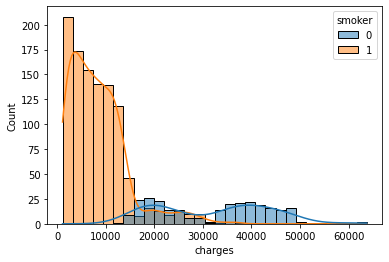

In [35]:
sns.histplot(data=med, x="charges",kde=True, hue = "smoker")

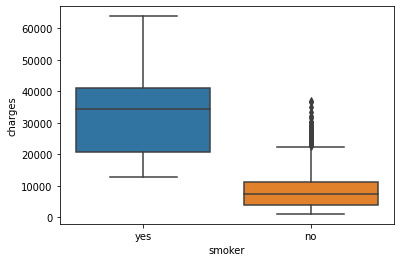

In [5]:
sns.boxplot(x="smoker", y="charges", data=med)

We also explore the relationship between `charges` and other variables and whether they are indicative of insurance payout in addition to `smoker`. The scatter plot between `age` and `charges` shows that there is an increasing trend where people at higher age experience higher expenses. The points form three increasing trends at different levels of charges. While `smoker` does help explain seprate some of these levels, there is other underlying patterns in place that we need to explore. 

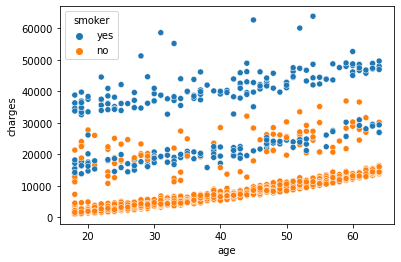

In [7]:
sns.scatterplot(data=med, x="age", y="charges",hue = "smoker")

Body mass index, `bmi`, is a person's weight divided by the square of height in meters. It is used as a screening tool for obesity and an important indicator for various metabolic and disease outcomes. In our analysis, we do not observe a linear relationship between `bmi` and `charges` however there are identifiable clusters. While bmi is not indicative of expenses for non-smokers whose records under \$15,000. Among smokers, those with bmi under 30 have medical payout between \$15,000 and \$30,000 and those with bmi above 30 have payout more than \$30,000.  

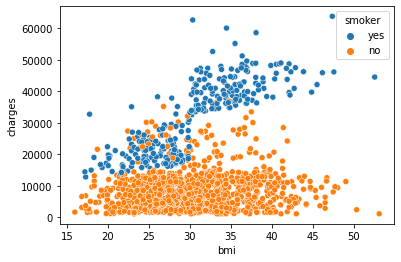

In [8]:
sns.scatterplot(data=med, x="bmi", y="charges",hue = "smoker")

As we further investigate with box plots of medical expenses by sex, number of children, and regions, we find no clear evidence that these variable are predictive of `charges`.

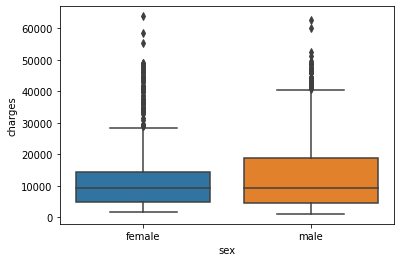

In [9]:
sns.boxplot(x="sex", y="charges", data=med)

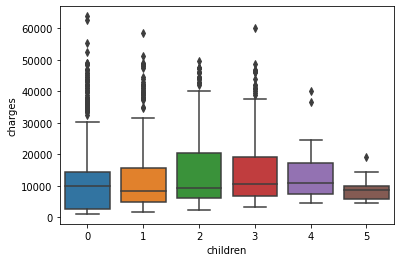

In [10]:
sns.boxplot(x="children", y="charges", data=med)

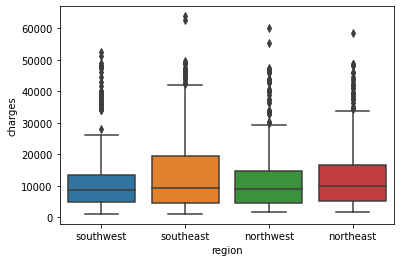

In [11]:
sns.boxplot(x="region", y="charges", data=med)

## Neural Networks Using Keras

We proceed to employ simple shallow and deep neural networks on six independent variables to predict `charges`. We use keras, a popular deep learning package which enables rapid implementation of neural networks. 

In [12]:
#convert object to numeric 
med['sex'] = pd.factorize(med.sex)[0]
med['smoker'] = pd.factorize(med.smoker)[0]
med['region'] = pd.factorize(med.region)[0]

In [13]:
#scaler
scalar = MinMaxScaler()
scalar.fit(med['charges'].values.reshape(-1, 1))
# split data into training and testing sets
y = scalar.transform(med['charges'].values.reshape(-1, 1))
x = med.drop('charges',axis=1)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y,random_state = 0, test_size = 0.2)

### Activation Functions

We experiment with different activation functions

* relu: Rectified Linear Unit Function
* tanh: Hyperbolic Tangent Function
* swish: Smooth, Non-Monotonic Function
* gelu: Gaussian Error Linear Unit Function

We used r-squared to compare the performance of each model and mean squared error loss function given our objective is a regression problem. With batch size of 100 and 150 epochs, we find that gelu function performs the best among the four with r-square above 86 percent.  


In [14]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='relu'),
                                 keras.layers.Dense(6, activation='relu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 2s 3ms/step - loss: 0.6856
Epoch 2/150
11/11 [==============================] - 0s 5ms/step - loss: 0.6806
Epoch 3/150
11/11 [==============================] - 0s 3ms/step - loss: 0.6619
Epoch 4/150
11/11 [==============================] - 0s 3ms/step - loss: 0.5877
Epoch 5/150
11/11 [==============================] - 0s 3ms/step - loss: 0.3234
Epoch 6/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 7/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 8/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 9/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0552
Epoch 10/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0517
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 12/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0452
Epoch 13/150
11/11 [=================

0.8004151712894213

In [15]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='tanh'),
                                 keras.layers.Dense(6, activation='tanh'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 0s 2ms/step - loss: 0.1002
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0717
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 9/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0361
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 13/150
11/11 [=================

0.7901321458547743

In [16]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='swish'),
                                 keras.layers.Dense(6, activation='swish'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0820
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0632
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0544
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0489
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 9/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 13/150
11/11 [=================

0.7789271688081039

In [36]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 1s 3ms/step - loss: 0.0737
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0736
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0734
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0709
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0561
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0520
Epoch 7/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0493
Epoch 9/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0491
Epoch 10/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0482
Epoch 11/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0472
Epoch 12/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 13/150
11/11 [=================

0.8615808810333506

### Optimizer

We also experiment with different optimizer:

* sgd: Stochastic Gradient Descent
* rmsprop: Root Mean Squared Propagation
* adam: Adaptive Moment Estimation

We find that the adam optimizer perform the best among the three optimizers. Thus we proceed to a deeper architecture with gelu activation function and adam optimizer. 

In [18]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="sgd")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 1s 2ms/step - loss: 0.6862
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6858
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6852
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6842
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6821
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6752
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.3777
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 9/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 11/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 13/150
11/11 [=================

-0.06665945562093589

In [19]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="rmsprop")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 1s 2ms/step - loss: 0.3501
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.2590
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.2077
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.1690
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.1406
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.1196
Epoch 7/150
11/11 [==============================] - 0s 3ms/step - loss: 0.1040
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0922
Epoch 9/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0837
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0760
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0745
Epoch 13/150
11/11 [=================

0.4170074799062581

In [20]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)
#r squared
r2_score(y_test, y_predict)

Epoch 1/150
11/11 [==============================] - 1s 2ms/step - loss: 0.6818
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6774
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6697
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6565
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6345
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.5974
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.5380
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.4494
Epoch 9/150
11/11 [==============================] - 0s 2ms/step - loss: 0.3357
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.2191
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0783
Epoch 13/150
11/11 [=================

0.798204334439455

### Deeper Architecture

While we experiment with different components of the neural networks setup, we employ a deeper architecture and observe whether this would improve the prediction performance. While there is a slight improvement on the r-squared at 87 percent, it is not significantly better than the shallow model. 

In [21]:
#keras model 
keras_model = keras.models.Sequential([keras.layers.Dense(6, input_dim=6, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(5, activation='gelu'),
                                 keras.layers.Dense(4, activation='gelu'),
                                 keras.layers.Dense(6, activation='gelu'),
                                 keras.layers.Dense(5, activation='gelu'),
                                 keras.layers.Dense(4, activation='gelu'),
                                 keras.layers.Dense(1, activation='sigmoid')])
keras_model.compile(loss="mean_squared_error", optimizer="adam")
keras_model.fit(x_train, y_train, batch_size =100, epochs=150)
y_predict = keras_model.predict(x_test)

Epoch 1/150
11/11 [==============================] - 1s 2ms/step - loss: 0.0663
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 3/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 6/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 9/150
11/11 [==============================] - 0s 3ms/step - loss: 0.0430
Epoch 10/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 11/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 12/150
11/11 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 13/150
11/11 [=================

In [22]:
from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.8747269930757647

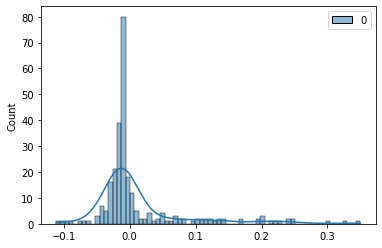

In [23]:
#error 
sns.histplot((y_test-y_predict),kde=True)

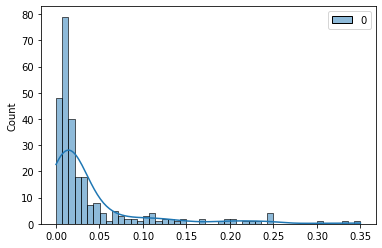

In [24]:
#absolute error
abs_err = abs(y_test-y_predict)
sns.histplot(abs_err,kde=True)

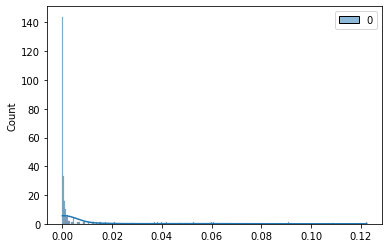

In [25]:
#squared error
sqr_err = (y_test-y_predict)**2
sns.histplot(sqr_err,kde=True)

**How many epochs are enough?**




Epoch 1/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 2/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 5/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 6/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 8/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 10/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.006

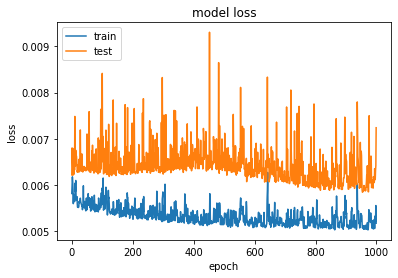

In [26]:
# Fit the model
history = keras_model.fit(x, y, validation_split=0.2, batch_size =100, epochs=1000)
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Visualize the deep models architecture**

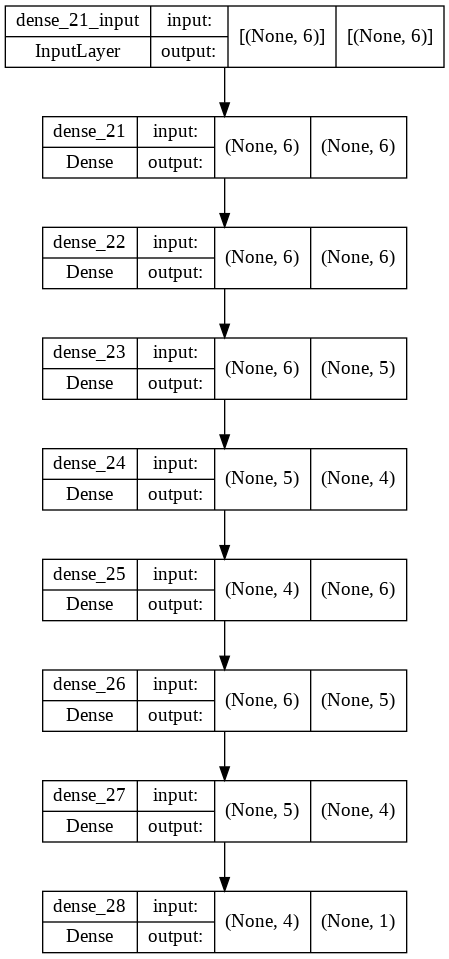

In [27]:
from keras.utils.vis_utils import plot_model

#plot_model(word2vec_model, to_file='word2vec_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(keras_model, show_shapes=True, show_layer_names=True)

### Variables Importance

In [28]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 30.7 MB/s 
     |████████████████████████████████| 133 kB 62.1 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=7eff6d4ea5acf9b01ef353e5d051d2b4c174f47df7d3f29266989449e754fdb6
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inc

In [29]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(keras_model, random_state=1,scoring = 'r2').fit(x,y)
eli5.show_weights(perm, feature_names = x.columns.tolist())

Weight,Feature
1.3478 ± 0.0740,smoker
0.2794 ± 0.0330,bmi
0.1769 ± 0.0103,age
0.0052 ± 0.0020,children
0.0021 ± 0.0013,region
-0.0004 ± 0.0025,sex


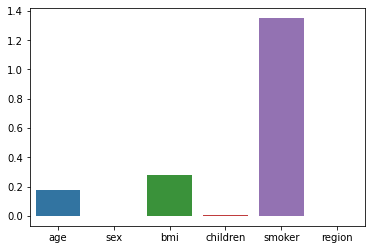

In [30]:
sns.barplot(y = perm.feature_importances_ , x = x.columns.tolist())

Lastly, we use the `eli5` package to explore the variable importance in our model performance. Unsurprisingly, we find `smoker`, `bmi`, and `age` to be the most important variables in predicting annual medical expenses. 